Project CMSE 201 Spring 2024 - Burke, Joseph
Volleyball Game Modeling

volleyball

skills and locations

pass stat - if in zone, player receive % (if rand.random(0,1)>receive%))

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
%matplotlib inline
from scipy.integrate import solve_ivp
import seaborn as sns
import random as rand

Stats and data come from NCAA college volleyball official reported individual player stats
https://www.ncaa.com/sports/volleyball-women/d1

In [2]:
stats = pd.read_csv('CollegeVballStats.csv', delimiter = ',',encoding = None)
stats.set_index(stats.columns[2], inplace=True)


In [3]:
stats.head(10)

,TEAM,#,SP,MP,MS,PTS,PTS/S,K,K/S,E,...,RE,RA,REC%,RE/S,BS,BA,BLK,BLK/S,BE,BHE
PLAYER,,,,,,,,,,,,,,,,,,,,,
"Ferreira, Elise",OREGON,1,78,24,1,19.0,0.24,0,0.00,0,...,0,0,0.000,0.00,0,0,0,0.00,0,0
"Thibault, Kate",OREGON,2,59,20,2,18.0,0.31,0,0.00,0,...,13,112,0.884,0.22,0,0,0,0.00,0,0
"Glover, Noemie",OREGON,3,11,8,0,13.5,1.23,12,1.09,7,...,0,2,1.000,0.00,0,3,3,0.27,1,0
"McClellan, Daley",OREGON,4,117,33,3,29.0,0.25,1,0.01,0,...,26,355,0.927,0.22,0,0,0,0.00,0,1
"Neal, Colby",OREGON,7,35,13,6,47.0,1.34,30,0.86,15,...,0,4,1.000,0.00,3,28,31,0.89,2,1
"Gonzales, Gabby",OREGON,8,123,34,34,393.5,3.20,347,2.82,109,...,48,973,0.951,0.39,2,33,35,0.28,2,2
"Pukis, Hannah",OREGON,9,123,34,34,181.5,1.48,105,0.85,32,...,1,6,0.833,0.01,7,77,84,0.68,13,5
"Murphy, Georgia",OREGON,10,123,34,0,24.0,0.20,2,0.02,0,...,24,470,0.949,0.20,0,0,0,0.00,1,2
"Lewis, Morgan",OREGON,11,121,34,29,402.0,3.32,351,2.90,95,...,1,12,0.917,0.01,6,90,96,0.79,3,3


In [4]:
stats.loc['Thibault, Kate','REC%']

0.884

Team Rosters

In [5]:
OREGONSUBS = ['Ferreira, Elise','McClellan, Daley','Neal, Colby','Glover, Noemie','Murphy, Georgia','Bacon, Karson','Pukis, Hannah']

OREGON = ['Pukis, Hannah','Gonzales, Gabby','McGhee, Kara','Lewis, Morgan','Colyer, Mimi','Bacon, Karson','Murphy, Georgia']

MSU = ['Bishop, Julia','Staniszewska, Karolina','Okur, Nil','Moore, Aliyah','Holdem, Taylah','Doezema, Evie','Horejsi, Avery']
TEXAS = ['Swindle, Ella', 'Skinner, Madisen',"O'neal, Asjia",'Phillips, Molly','Wenaas, Jenna', 'Singletary, Marianna','Barnes, Carissa']
WISCONSIN = ['']

Setup and individual gameplay functions

In [6]:
def roster(Team,S,OH1,MB2,RSDS,OH2,MB1,LIB,rotation=1):
    team = Team
    setter = S
    outside1 = OH1
    middle2 = MB2
    rightside = RSDS
    outside2 = OH2
    middle1 = MB1
    libero = LIB
    
    lineup = np.array([[RSDS, MB2, OH1],
                     [OH2, MB1, S]])
    rotation = rotation
    
    return lineup , rotation
    

In [7]:
def rotate(original_array,rotation): 
    clockwise_rotated_array = np.zeros_like(original_array)
    
    array = original_array
    
    clockwise_rotated_array[0, 0] = array[1, 0]
    clockwise_rotated_array[0, 1] = array[0, 0]
    clockwise_rotated_array[0, 2] = array[0, 1]
    clockwise_rotated_array[1, 2] = array[0, 2]
    clockwise_rotated_array[1, 1] = array[1, 2]
    clockwise_rotated_array[1, 0] = array[1, 1]
                
    rotation +=1
    if rotation == 7:
        rotation = 1
    return clockwise_rotated_array, rotation

In [8]:
def whoserves (team, lineup, rotation):
    if team == team1:
        i = 0
    else:
        i = 1
        
    server = lineup[1, 2]
    
    return server

In [9]:
def serve(server):
    server = str(server)
    se = stats.loc[server ,'SE']/stats.loc[server ,'SP']/3 #Server's serve errors per set, divided by three to calculate likelyhood of serve error per serve
    z = rand.random() #random value used to calculate players aiming - irl aiming is usually strategically to weakest serve receive player, but teams can counter this as well 
    if se == 0: #for players who did not record serve statistics, logs a 'basic' serve that misses 10% of the time.
        se=.10
    if z < se:
        zone = 0 #zone 0 = out of bounds, in the net, or foot fault, and point to the other team
    else:
        x = rand.uniform(0,100)
        if x >= 0 and x < 30:
            zone = 1
        elif x>=30 and x < 60:
            zone=6
        elif x>=60 and x <90:
            zone=5
        elif x>=90 and x <93.33:
            zone=4
        elif x>=93.33 and x <96.67:
            zone=3
        else:
            zone=2
    if zone == 0:
        zone = 0
    return server, zone

In [10]:
def whoreceive(team, lineup,zone):
    if zone == 1:
        receiver = lineup[1, 2]
    if zone == 2:
        receiver = lineup[0, 2]
    if zone == 3:
        receiver = lineup[0, 1]        
    if zone == 4:
        receiver = lineup[0, 0]        
    if zone == 5:
        receiver = lineup[1, 0]
    if zone == 6:
        receiver = lineup[1, 1] 
        
    return team, receiver
        

In [11]:
def servereceive(team, receiver, server, zone):
    r = stats.loc[receiver,'REC%']
    sa = stats.loc[server ,'SA/S']/4
    a= (1-sa-r)
    if sa == 0:
        a = -.1
    #print(r, sa, a)
    r0 = .1+a
    r1 = r0+.20
    r2 = r1+.30
    r3 = r2+.40
    r4 = r3+.0
    x = rand.random()
    if x >= 0 and x < r0:
        receive = 0
    elif x>=r0 and x < r1:
        receive=1
    elif x>=r1 and x <r2:
        receive=2
    elif x>=r2 and x <r3:
        receive=3
    else:
        receive=4
    return receive


In [12]:
def servevservereceive(server,receiver,tests=100,sample=100,color='red'):
    countzeros = []
    for i in range(0,tests):
        receivelist = []
        for i in range(0,sample):
            receivelist.append(servereceive(receiver, serve(server)[0], serve(server)[1]   )) 
        countzeros.append(receivelist.count(0))
    name = str(server)+' v '+str(receiver)
    plt.hist(countzeros,label=name,color=color)
    plt.title('1v1 S & SR Matchups')
    plt.xlabel('SR Errors')
    plt.ylabel('Frequency')
    plt.legend()

In [13]:
def setting(team, setter, rotation, receive):
    
    #if gender == male:
     #   d += .10
#women
    if rotation == 2 or  rotation == 3 or rotation == 4:
        if receive == 4:
            o = .24
            m = .41
            r = .24
            p = .11
            d = .000
            b = .000
        elif receive == 3:
            o = .28
            m = .32
            r = .34
            p = .06
            d = .000
            b = .000
        elif receive == 2:
            o = .46
            m = .10
            r = .38
            p = .04
            d = .01
            b = .01
        elif receive == 1:
            o = .54
            m = .05
            r = .35
            p = .04
            d = .01
            b = .01   
            
    if rotation == 1 or  rotation == 5 or rotation == 6:
#women
        if receive == 4:
            o = .33
            m = .54
            r = .03
            p = .10
            d = .00
            b = .000
        elif receive == 3:
            o = .41
            m = .48
            r = .01
            p = .10
            d = .000
            b = .000
        elif receive == 2 :
            o = .64
            m = .27
            r = .00
            p = .08
            d = .01
            b = .00
        elif receive == 1:
            o = .78
            m = .10
            r = .00
            p = .06
            d = .05
            b = .01    
    
            
    x = rand.random()
    if x >= 0 and x < o:
        set = 4
    elif x>=o and x < o+m:
        set = 3
    elif x>=o+m and x <o+m+r:
        set = 2
    elif x>=o+m+r and x <o+m+r+p:
        set = 6
    elif x>=o+m+r+p and x <o+m+r+p+d:
        set = 1
    else:
        set = 5
            
    return setter, set

    
    

In [14]:
def who_hits(team, lineup, rotation, setter, set):
    
    if rotation == 1:
        setter = lineup[1, 2] 
        outside1 = lineup[0, 2] 
        middle2 = lineup[0, 1] 
        rightside = lineup[0, 0]
        outside2 = lineup[1, 0]
        middle1 = lineup[1, 1]
        
    if rotation == 2:
        outside1 = lineup[1, 2] 
        middle2 = lineup[0, 2] 
        rightside = lineup[0, 1] 
        outside2 = lineup[0, 0]
        middle1 = lineup[1, 0]
        setter = lineup[1, 1]
    
    if rotation == 3:
        middle2 = lineup[1, 2] 
        rightside = lineup[0, 2] 
        outside2 = lineup[0, 1] 
        middle1 = lineup[0, 0]
        setter = lineup[1, 0]
        outside1 = lineup[1, 1]
    
    if rotation == 4:
        rightside = lineup[1, 2] 
        outside2 = lineup[0, 2] 
        middle1 = lineup[0, 1] 
        setter = lineup[0, 0]
        outside1 = lineup[1, 0]
        middle2 = lineup[1, 1]
        
    if rotation == 5:
        outside2 = lineup[1, 2] 
        middle1 = lineup[0, 2] 
        setter = lineup[0, 1] 
        outside1 = lineup[0, 0]
        middle2 = lineup[1, 0]
        rightside = lineup[1, 1]
        
    if rotation == 6:
        middle1 = lineup[1, 2] 
        setter = lineup[0, 2] 
        outside1 = lineup[0, 1] 
        middle2 = lineup[0, 0]
        rightside = lineup[1, 0]
        outside2 = lineup[1, 1]
        

    if rotation == 1 or  rotation == 5 or rotation == 6: 
        if set == 4:
            hitter = outside1
        if set == 6:
            hitter = outside2
    
    if rotation == 2 or  rotation == 3 or rotation == 4: 
        if set == 4:
            hitter = outside2
        if set == 6:
            hitter = outside1
    
    if rotation == 1 or  rotation == 2 or rotation == 3: 
        if set == 2:
            hitter = rightside
        if set == 1:
            hitter = setter
    
    if rotation == 4 or  rotation == 5 or rotation == 6: 
        if set == 2:
            hitter = setter
        if set == 1:
            hitter = rightside
    
    if rotation == 3 or  rotation == 4 or rotation == 5: 
        if set == 3:
            hitter = middle1
        if set == 5:
            hitter = middle2 #libero
    
    if rotation == 1 or  rotation == 2 or rotation == 6: 
        if set == 3:
            hitter = middle2
        if set == 5:
            hitter = middle1 #libero
            

    
    return hitter, setter
    
    

In [15]:
def attack (team, spiker, setter):
    z = rand.random()
    hitattempts = stats.loc[spiker,'HA']
    if hitattempts == 0:
        hitattempts = 1
        
    x = rand.random()
    if x >= 0 and x < 30:
        area = 1
    elif x>=30 and x < 60:
        area=6
    elif x>=60 and x <90:
        area=5
    elif x>=90 and x <93.33:
        area=4
    elif x>=93.33 and x <96.67:
        area=3
    else:
        area=2
        
    kpct = stats.loc[spiker,'K']/hitattempts
    epct = stats.loc[spiker,'E']/hitattempts
     
    if z >=0 and z <epct:
        hit = 'error'
    elif z>=epct and z < epct+kpct:
        hit = 'kill'
    else:
        hit = 'zeroatk'

        
    return hit, area

In [16]:
def dig (team, hit, area):
    if hit == 'zeroatk':
        #d = stats.loc[digger,'DIG/S']
        up = 2
    else:
        up = 0
    return up 

Gameplay functions

In [17]:
def offense(team1, team2, team, lineup, rotation, setter, receive): 
    
    setter, set = setting(team, setter, rotation, receive)
    hitter, setter = who_hits(team, lineup, rotation, setter, set)
    hit, area = attack (team, hitter, setter)
    
    if team == team2:
        if hit == 'kill':
            winteam = team2 
            result =  team2,hitter,'kill'
            return winteam, result

        elif hit == 'error':
            winteam = team1 
            result =  team2,hitter, 'hit error'
            return winteam, result
            
        else:
            receive = dig(team1, hit, area)
            winteam, result = offense(team1,team2,team1, lineup1, rotation1, setter1, receive)
            return winteam, result

            
    elif team == team1:
        if hit == 'kill':
            winteam = team1 
            result =  team1, hitter,'kill'
            return winteam, result
    
        elif hit == 'error':
            winteam = team2 
            result =  team1,hitter,'hit error'
            return winteam, result
                
        else:
            receive = dig(team2, hit, area)
            winteam, result = offense(team1, team2, team2, lineup2, rotation2, setter2, receive)
            return winteam, result


In [18]:
def pointstart(team1, team2, team, lineup, rotation ,lineup2, rotation2): 
    
    serveteam = team
    
    server, zone = serve(whoserves(team, lineup, rotation)) 
    
    if serveteam == team1:
        if zone == 0:
            winteam = team2
            result =  team1,server,'serve error'
            return winteam, result, serveteam
            
        else:
            team, who = whoreceive(team2, lineup2,zone)
            receive = servereceive(team, who, server, zone)
            if receive == 0:
                winteam = team1 
                result =  team1,server,'servic eace'
                return winteam, result, serveteam

                
            else:
                winteam, result = offense(team1,team2,team2, lineup2, rotation2, setter2, receive)
                return winteam, result, serveteam
                
            
    elif serveteam == team2:
        if zone == 0:
            winteam = team1 
            result =  team2,server,'serve error'
            return winteam, result, serveteam

            
        else:
            team, who = whoreceive(team1, lineup1,zone)
            receive = servereceive(team, who, server, zone)
            if receive == 0:
                winteam = team2 
                result =  team2,server, 'service ace'
                return winteam, result, serveteam

            else:
                winteam, result = offense(team1,team2, team1, lineup1, rotation1, setter1, receive)
                return winteam, result, serveteam
                

In [19]:
def cointoss(team1,lineup1,rotation1,team2,lineup2,rotation2):
    x = rand.random()
    if x <= .5:
        winteam = team1
    else:
        winteam = team2
        
    if winteam == team1:
        winteamlineup = lineup1
        winteamrotation = rotation1
        loseteamlineup = lineup2
        loseteamrotation = rotation2
        
    elif winteam == team2:
        winteamlineup = lineup2
        winteamrotation = rotation2
        loseteamlineup = lineup1
        loseteamrotation = rotation1
        
    return winteam, winteamlineup, winteamrotation, loseteamlineup, loseteamrotation

In [20]:
def initiate(team1, team2, roster1,roster2, rotation1=1,rotation2=1,team1score=0,team2score=0):
    team1score = 0
    team2score = 0
    
    starters1,rotation1 = roster(team1,roster1[0],roster1[1],roster1[2],roster1[3],roster1[4],roster1[5],roster1[6],rotation1)
    starters2,rotation2 = roster(team2,roster2[0],roster2[1],roster2[2],roster2[3],roster2[4],roster2[5],roster2[6],rotation2)
    
    lineup1 = starters1
    lineup2 = starters2
    
    setter1 = roster1[rotation1-1]
    setter2 = roster2[rotation1-1]
    
    return team1, team2, lineup1, rotation1, setter1, lineup2, rotation2, setter2,team1score,team2score
    
    

Now to start a game

In [21]:
team1, team2, lineup1, rotation1, setter1, lineup2, rotation2, setter2,team1score,team2score = initiate('Oregon','Texas',OREGON,TEXAS,1,1)

winteam, winteamlineup, winteamrotation, loseteamlineup, loseteamrotation = cointoss(team1,lineup1,rotation1,team2,lineup2,rotation2)

print('cointoss win and first serve:', winteam)

while team1score <25 and team2score <25: # and abs(team1score-team2score) < 2:
    
    print('------------')
    print('rotation',team1,rotation1, ':',team2,rotation2)
    
    winteam, result, serveteam = pointstart(team1, team2, winteam, winteamlineup, winteamrotation,loseteamlineup,loseteamrotation)

    print(result)
    print('point:',winteam)
    

    if winteam != serveteam:
        if winteam == team1:
            lineup1, rotation1 = rotate(lineup1,rotation1) 
        elif winteam == team2:
            lineup2, rotation2 = rotate(lineup2,rotation2)    
    
    if winteam == team1:
        team1score += 1
        winteamlineup = lineup1
        winteamrotation = rotation1
        loseteamlineup = lineup2
        loseteamrotation = rotation2
        
    elif winteam == team2:
        team2score += 1
        winteamlineup = lineup2
        winteamrotation = rotation2
        loseteamlineup = lineup1
        loseteamrotation = rotation1
        
    print('Score:',team1,':',team1score,' , ', team2,':',team2score)

cointoss win and first serve: Texas
------------
rotation Oregon 1 : Texas 1
('Texas', 'Skinner, Madisen', 'kill')
point: Texas
Score: Oregon : 0  ,  Texas : 1
------------
rotation Oregon 1 : Texas 1
('Texas', 'Swindle, Ella', 'serve error')
point: Oregon
Score: Oregon : 1  ,  Texas : 1
------------
rotation Oregon 2 : Texas 1
('Texas', 'Skinner, Madisen', 'kill')
point: Texas
Score: Oregon : 1  ,  Texas : 2
------------
rotation Oregon 2 : Texas 2
('Texas', 'Skinner, Madisen', 'service ace')
point: Texas
Score: Oregon : 1  ,  Texas : 3
------------
rotation Oregon 2 : Texas 2
('Oregon', 'Lewis, Morgan', 'kill')
point: Oregon
Score: Oregon : 2  ,  Texas : 3
------------
rotation Oregon 3 : Texas 2
('Oregon', 'Colyer, Mimi', 'kill')
point: Oregon
Score: Oregon : 3  ,  Texas : 3
------------
rotation Oregon 3 : Texas 2
('Oregon', 'Colyer, Mimi', 'kill')
point: Oregon
Score: Oregon : 4  ,  Texas : 3
------------
rotation Oregon 3 : Texas 2
('Oregon', 'Colyer, Mimi', 'kill')
point: Oregon

In [22]:
def model_games(team1, team2, roster1,roster2, rotation1=1,rotation2=1,team1score=0,team2score=0):
    
    team1, team2, lineup1, rotation1, setter1, lineup2, rotation2, setter2,team1score,team2score = initiate(team1, team2, roster1, roster2, rotation1,rotation2,team1score,team2score)

    winteam, winteamlineup, winteamrotation, loseteamlineup, loseteamrotation = cointoss(team1,lineup1,rotation1,team2,lineup2,rotation2)

    while team1score <25 and team2score <25: # and abs(team1score-team2score) < 2:
    
        winteam, result, serveteam = pointstart(team1, team2, winteam, winteamlineup, winteamrotation,loseteamlineup,loseteamrotation)

        if winteam != serveteam:
            if winteam == team1:
                lineup1, rotation1 = rotate(lineup1,rotation1) 
            elif winteam == team2:
                lineup2, rotation2 = rotate(lineup2,rotation2)    
    
        if winteam == team1:
            team1score += 1
            winteamlineup = lineup1
            winteamrotation = rotation1
            loseteamlineup = lineup2
            loseteamrotation = rotation2
        
        elif winteam == team2:
            team2score += 1
            winteamlineup = lineup2
            winteamrotation = rotation2
            loseteamlineup = lineup1
            loseteamrotation = rotation1
        
    return team1score, team2score 

(array([610.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 390.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

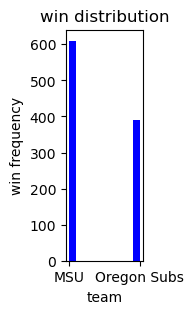

In [57]:
team1 = 'MSU'
team2 = 'Oregon Subs'

team1scores = []
team2scores = []
winner= []

for i in range(1000):
    team1score, team2score = model_games(team1,team2,MSU,OREGONSUBS,1,1,0,0)

    team1scores.append(team1score)
    team2scores.append(team2score)
    
    if team1score>team2score:
        winner.append(team1)
    if team2score>team1score:
        winner.append(team2)
        
#plt.scatter(team1scores,team2scores,label='score spread')
#plt.title('score distribution')
#plt.xlabel('t1score')
#plt.ylabel('t2score')

plt.figure(figsize=(1, 3))
plt.title('win distribution')
plt.xlabel('team')
plt.ylabel('win frequency')
plt.hist(winner,label='winners',color='blue')
    


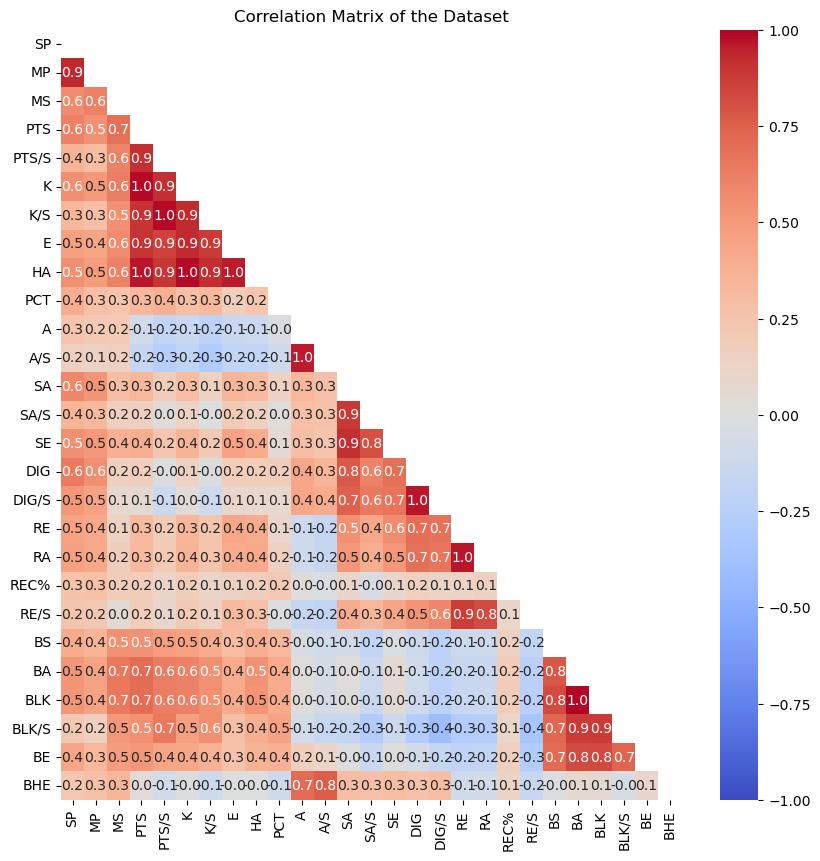

In [53]:
#def whichstats(team1, team2, roster1,roster2,rotation1=1,rotation2=1,team1score=0,team2score=0):
team1 = 'MSU'
team2 = 'Oregon Subs'

roster1 = MSU
roster2 = OREGONSUBS
    
team1score, team2score = model_games(team1,team2,roster1,roster2,1,1,0,0)


stats_df = stats.drop(["#",], axis = 1)

    
corr_matrix = stats_df.corr(numeric_only = True)

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plotting the correlation matrix using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, 
                         annot=True, # put the correlation coefficient in the plot
                         vmin = -1, vmax = 1, # set the limits equal for all the plots
                         fmt=".1f", # only 2 decimal digits
                         cmap='coolwarm', # color map
                         mask=mask # plot only the off-diagonal elements of the correlational matrix.
           )
plt.title('Correlation Matrix of the Dataset')
plt.show()


In [ ]:
for i in stats['PLAYER']:
    for j in stats:
        servevservereceive(server,receiver,tests=100,sample=100,color='red')